In [4]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

  Using cached tensorflow_gpu-2.7.0-cp37-cp37m-win_amd64.whl (430.8 MB)


In [4]:
# import dependencies 
import cv2
import os 
import random 
import numpy as np
from matplotlib import pyplot as plt

In [5]:
# import tensorflow dependencies 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf 

In [6]:
# set gpu growth 
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
len(gpus)

0

In [9]:
# create Folder structures
# setup paths 
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [7]:
# make directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [7]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [16]:
for directory in os.listdir('lfw'): 
    for file in os.listdir(os.path.join('lfw', directory)): 
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [10]:
# import uid library to generate unique image names 
import uuid

In [11]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\3ba25152-8b7a-11ec-bd66-34de1abed394.jpg'

In [10]:
# Establish connection to the webcam: 
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()

    # resize frame to be same as negative pictures
    frame = frame[120:120+250, 200:200+250, :]

    # collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # create unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # write out anchor image
        cv2.imwrite(imgname, frame)

    # collect positives 
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # create unique file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # write out positive image
        cv2.imwrite(imgname, frame)
    # show image back to screen 
    cv2.imshow('Image Collection', frame)


  
    # break and close down frames 
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
# release webcam
cap.release()
# close image show frame
cv2.destroyAllWindows()


In [12]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [13]:
# preprocessing - scale and resize 
def preprocess(file_path): 

    # read in image from file path 
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing steps - resize img to 100x100x3
    img = tf.image.resize(img, (100,100))
    # scale image to be between 0 and 1
    img = img / 255.0

    return img

In [14]:
# Create labelled dataset 
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [15]:
# build train and test sets 
def preprocess_twin(input_img, validation_img, label): 
    return(preprocess(input_img), preprocess(validation_img), label)

In [16]:
# get an example to see if it has an actual image
samples = data.as_numpy_iterator()
example = samples.next()

In [17]:
example

(b'data\\anchor\\44fb6e52-73e1-11ec-9697-34de1abed394.jpg',
 b'data\\positive\\6db6e864-73e1-11ec-b395-34de1abed394.jpg',
 1.0)

In [18]:
res = preprocess_twin(*example)

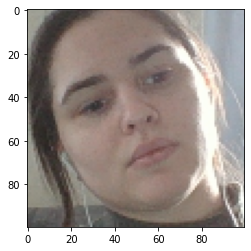

In [19]:
plt.imshow(res[1])

In [20]:
res[2]

1.0

In [21]:
# Build dataloader pipeline 
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [22]:
# Training partitition 
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [23]:
train_data

<PrefetchDataset shapes: ((None, 100, 100, None), (None, 100, 100, None), (None,)), types: (tf.float32, tf.float32, tf.float32)>

In [27]:
# Testing set 
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)


Build Embedding Layer

In [28]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')

    # first block 
    conv1 = Conv2D(64, (10,10), activation='relu')(inp)
    max1 = MaxPooling2D(64, (2, 2), padding='same')(conv1)

    # second block 
    conv2 = Conv2D(128, (7,7), activation='relu')(max1)
    max2 = MaxPooling2D(64, (2,2), padding='same')(conv2)

    # third block 
    conv3 = Conv2D(128, (4,4), activation='relu')(max2)
    max3 = MaxPooling2D(64, (2,2), padding='same')(conv3)

    # final embedding block 
    conv4 = Conv2D(256, (4, 4), activation='relu')(max3)
    flat1 = Flatten()(conv4)
    dense1 = Dense(4096, activation='sigmoid')(flat1)

    return Model(inputs=[inp], outputs=[dense1], name='embedding')


In [29]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

Build Distance Layer

In [30]:
# siamese L1 distance class 
class L1Dist(Layer): 

    # init method
    def __init__(self, **kwargs): 
        super().__init__()

    # similarity calculation 
    def call(self, input_embedding, validation_embedding): 
        return tf.math.abs(input_embedding - validation_embedding)

In [25]:
l1 = L1Dist()


Make the Siamese Model

In [31]:
def make_siamese_model(): 

    # anchor image input in network
    input_image = Input(name='input_img', shape=(100, 100, 3))

    # validation image in network 
    validation_image = Input(name='validation_img', shape=(100,100,3))

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # classification layer 
    # are these 2 images similar enough to be considered same person?
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [32]:
siamese_model = make_siamese_model()

In [33]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

Training 

In [34]:
# Define loss
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [35]:
# define optimizer and learning rate
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(lr)

In [36]:
# establish checkpoints 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=optimizer, siamese_model=siamese_model)


In [37]:
# Training step 
@tf.function
def train_step(batch): 
    #Record all of the operations
    with tf.GradientTape() as tape: 
        #get anchor and positive/negative image
        X = batch[:2]
        # get label 
        y = batch[2]

        # forward pass 
        yhat = siamese_model(X, training=True) 
        # calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)

    #calculate gradients 
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    #calculate updated weights and apply to siamese model 
    optimizer.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # return loss
    return loss

In [38]:
# import metric calculations 
from tensorflow.keras.metrics import Precision, Recall 

In [39]:
# Build training loop 
def train(data, EPOCHS): 
    # loop through epochs
    for epoch in range(1, EPOCHS+1): 
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Create a metric object 
        r = Recall()
        p = Precision()
    # loop through each batch 
    for idx, batch in enumerate(data): 
        # run train step 
        loss = train_step(batch)
        yhat = siamese_model.predict(batch[:2])
        r.update_state(batch[2], yhat)
        p.update_state(batch[2], yhat)
        progbar.update(idx+1)
    print(loss.numpy, r.result().numpy(), p.result().numpy())

    # save checkpoints
    if epoch % 10 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

In [40]:
# Set number of epochs
EPOCHS = 50

In [42]:
# Train the model 
train(train_data, EPOCHS)


 Epoch 1/50

 Epoch 2/50

 Epoch 3/50

 Epoch 4/50

 Epoch 5/50

 Epoch 6/50

 Epoch 7/50

 Epoch 8/50

 Epoch 9/50

 Epoch 10/50

 Epoch 11/50

 Epoch 12/50

 Epoch 13/50

 Epoch 14/50

 Epoch 15/50

 Epoch 16/50

 Epoch 17/50

 Epoch 18/50

 Epoch 19/50

 Epoch 20/50

 Epoch 21/50

 Epoch 22/50

 Epoch 23/50

 Epoch 24/50

 Epoch 25/50

 Epoch 26/50

 Epoch 27/50

 Epoch 28/50

 Epoch 29/50

 Epoch 30/50

 Epoch 31/50

 Epoch 32/50

 Epoch 33/50

 Epoch 34/50

 Epoch 35/50

 Epoch 36/50

 Epoch 37/50

 Epoch 38/50

 Epoch 39/50

 Epoch 40/50

 Epoch 41/50

 Epoch 42/50

 Epoch 43/50

 Epoch 44/50

 Epoch 45/50

 Epoch 46/50

 Epoch 47/50

 Epoch 48/50

 Epoch 49/50

 Epoch 50/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 1314s 48s/step
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.048951503>> 0.

In [43]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [59]:
# make predictions 
y_hat = siamese_model.predict([test_input, test_val])

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x0000015D259C3730>
Traceback (most recent call last):
  File "C:\Users\Owner\miniconda3\envs\detection-env\lib\weakref.py", line 357, in remove
    self = selfref()
KeyboardInterrupt


In [45]:
# Post processing the results to get answers of either 0 for images not of same person and 1 for images of same person 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0]

In [46]:
y_true # compare to true labels 

array([0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0.],
      dtype=float32)

Calculate Metrics

In [49]:

r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())



0.9010989 0.9879518


Save model 

In [50]:
# Save model weights
siamese_model.save('siamesemodelv2.h5')



In [52]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [53]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

array([[8.662816e-05],
       [9.426464e-01],
       [8.787968e-01],
       [7.775779e-01]], dtype=float32)

In [54]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][